# **Required Libraries & Configurations**

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4

2026-02-04 11:03:39.046141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770203019.543500      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770203019.704098      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770203020.957600      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770203020.957655      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770203020.957658      55 computation_placer.cc:177] computation placer alr

In [ ]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 70

# **Dataset Preparation**

In [ ]:
DATASET_PATH = "/kaggle/input/teeth-dataset/Teeth_Dataset"

TRAIN_DIR = f"{DATASET_PATH}/Training"
VAL_DIR   = f"{DATASET_PATH}/Validation"
TEST_DIR  = f"{DATASET_PATH}/Testing"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3087 files belonging to 7 classes.


I0000 00:00:1770203043.414338      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770203043.420583      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


# **Visualizations**

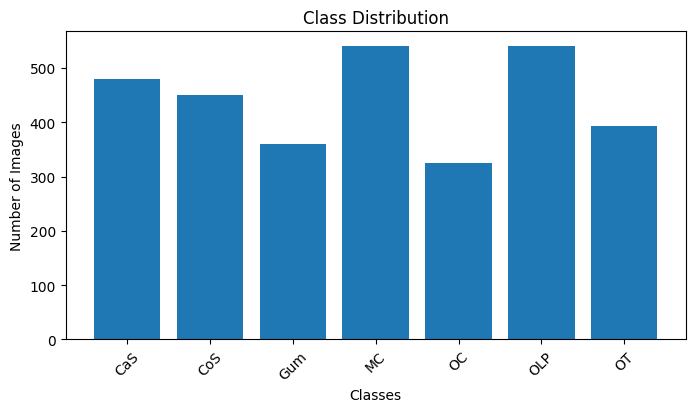

In [5]:
def plot_class_distribution(dataset, class_names):
    counts = np.zeros(len(class_names))
    for _, labels in dataset:
        counts += labels.numpy().sum(axis=0)

    plt.figure(figsize=(8, 4))
    plt.bar(class_names, counts)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_ds, class_names)

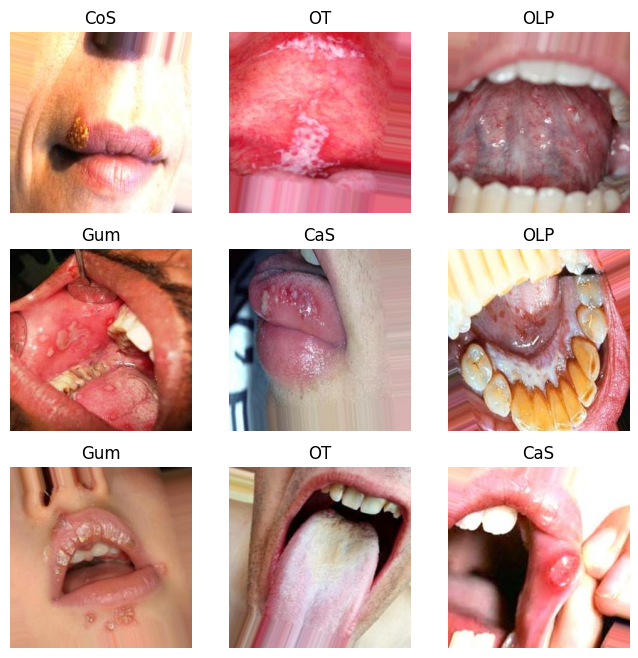

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

# **Augmentation**

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.Rescaling(1./255),
])

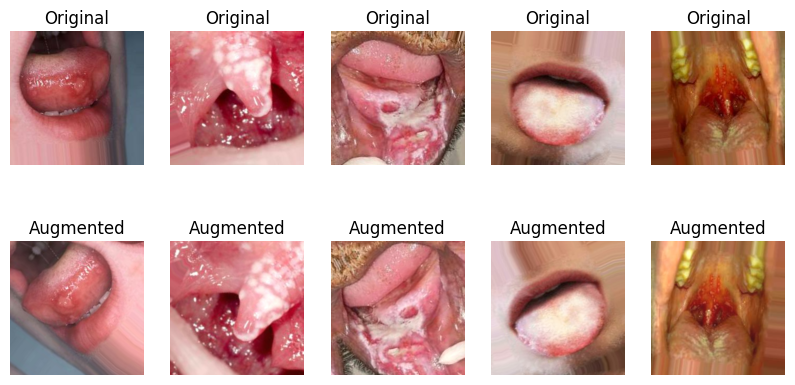

In [8]:
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)

    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Original
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Augmented
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_images[i].numpy())
        plt.title("Augmented")
        plt.axis("off")

    plt.show()

# **EfficientNetB4 Model**

In [ ]:
base_model = EfficientNetB4(
    weights=None,                # No pretrained weights
    include_top=False,
    input_shape=(256, 256, 3)
)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 17,561,167 (66.99 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/70


E0000 00:00:1770203121.455303      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1770203130.953488     131 cuda_dnn.cc:529] Loaded cuDNN version 91002


97/97 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.1883 - loss: 1.9722 - val_accuracy: 0.1449 - val_loss: 1.9562
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2348 - loss: 1.8903 - val_accuracy: 0.1449 - val_loss: 2.0543
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2595 - loss: 1.8412 - val_accuracy: 0.1449 - val_loss: 2.2778
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2831 - loss: 1.7956 - val_accuracy: 0.1449 - val_loss: 2.4425
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2828 - loss: 1.7626 - val_accuracy: 0.1449 - val_loss: 3.0981
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2907 - loss: 1.7456 - val_accuracy: 0.1449 - val_loss: 2.5667
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2977 - loss: 1.7301 - val_accuracy: 0.2179 - val_loss: 2.1431
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3362 - loss: 1.7150 - val_accuracy: 0.2695 - val_loss: 1.

In [ ]:
model.save("efficientnet_b4_model.keras")

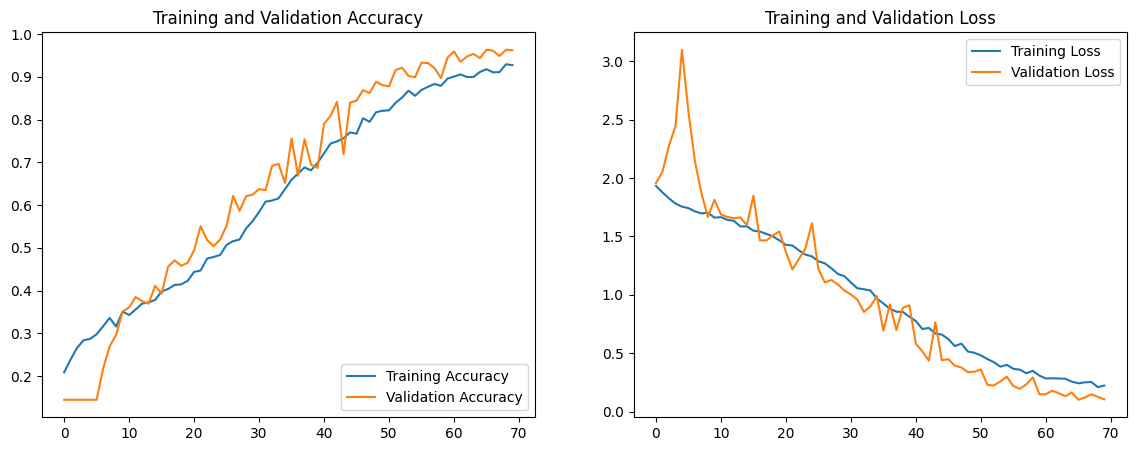

In [13]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<Figure size 800x800 with 0 Axes>

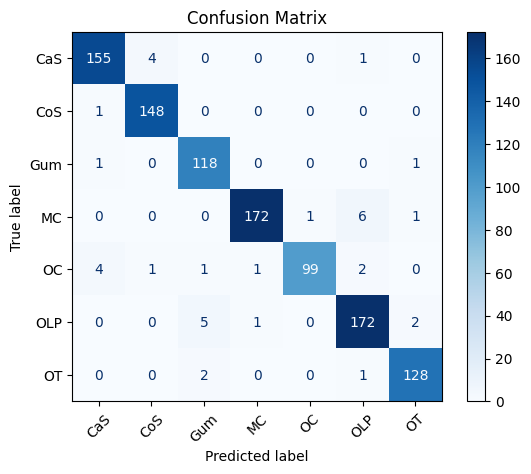

In [14]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

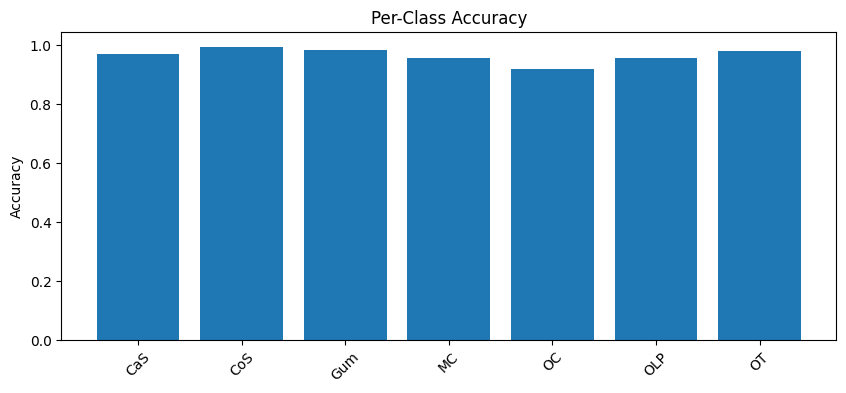

In [15]:
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

for i in range(len(y_true)):
    label = y_true[i]
    class_total[label] += 1
    if y_true[i] == y_pred[i]:
        class_correct[label] += 1

plt.figure(figsize=(10, 4))
plt.bar(
    class_names,
    class_correct / class_total
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


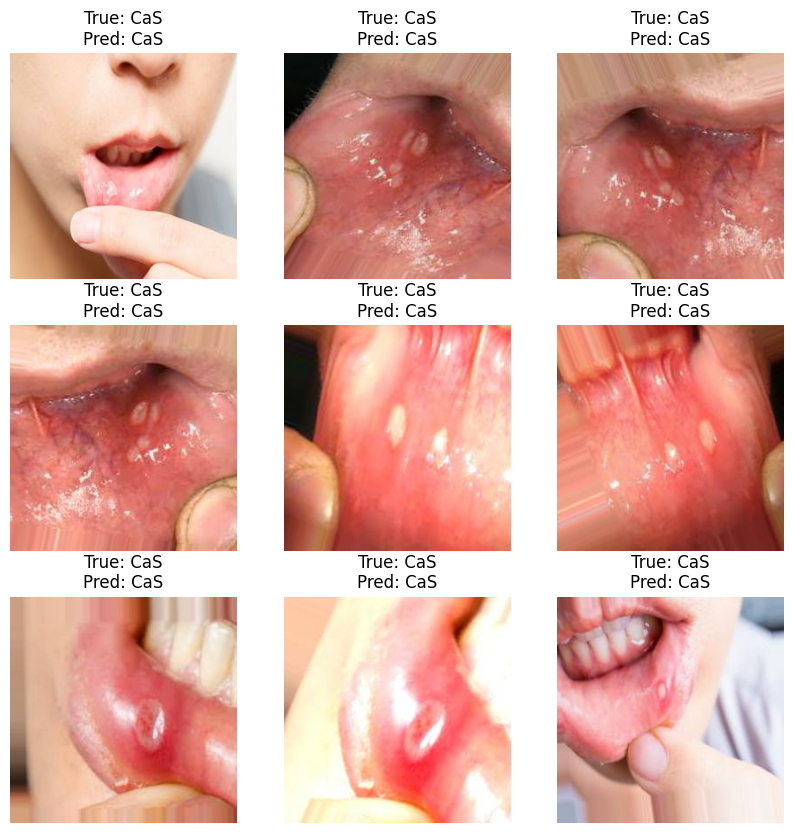

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(preds[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9714 - loss: 0.0850
Test Accuracy: 0.9650


In [18]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


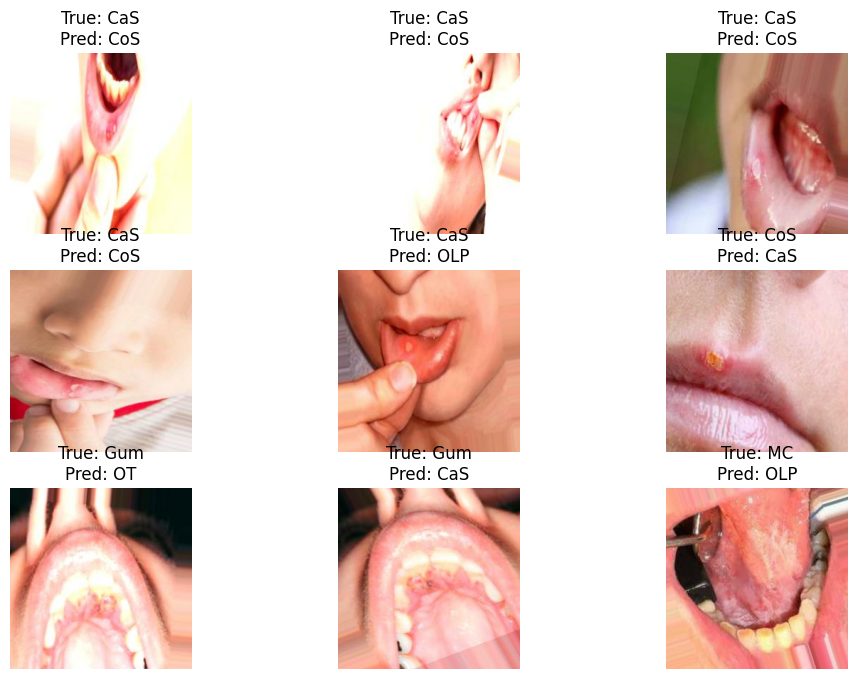

In [19]:
plt.figure(figsize=(12, 8))
shown = 0

for images, labels in test_ds:
    preds = model.predict(images)
    for i in range(len(images)):
        true = np.argmax(labels[i])
        pred = np.argmax(preds[i])
        if true != pred and shown < 9:
            plt.subplot(3, 3, shown + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
            plt.axis("off")
            shown += 1
    if shown >= 9:
        break

plt.show()